- Distributions
- Outliers
- Clustering
- Remove redundant variables
- Variable selection

Target: `price`

Feature == Important == In-between == Not-important ==Reason

1. **daft_id**:
    - Verdict:
    - Reason:
2. **url**:
    - Verdict:
    - Reason:
3. **name**:
    - Verdict:
    - Reason:
4. **price**:
    - Verdict:
    - Reason:
5. **sale_type**:
    - Verdict:
    - Reason:
6. **floor_area**:
    - Verdict:
    - Reason:
7. **entered_renewed**:
    - Verdict:
    - Reason:
8. **views**:
    - Verdict:
    - Reason:
9. **type**:
    - Verdict:
    - Reason:
10. **scraping_date**:
    - Verdict:
    - Reason:
11. **latitude**:
    - Verdict:
    - Reason:
12. **longitude**:
    - Verdict:
    - Reason:
13. **bedroom**:
    - Verdict:
    - Reason:
14. **bathroom**:
    - Verdict:
    - Reason:
15. ****:
    - Verdict:
    - Reason:
16. ****:
    - Verdict:
    - Reason:



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

In [3]:
sale_data = pd.read_csv('data_available/sale_data_post_C&W.csv', sep=',', parse_dates=['entered_renewed', 'scraping_date'])
sale_data.shape

(7695, 15)

In [4]:
sale_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7695 entries, 0 to 7694
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   daft_id          7695 non-null   int64         
 1   url              7695 non-null   object        
 2   name             7695 non-null   object        
 3   price            7695 non-null   float64       
 4   sale_type        7695 non-null   object        
 5   floor_area       7695 non-null   int64         
 6   entered_renewed  7695 non-null   datetime64[ns]
 7   views            7695 non-null   float64       
 8   type_house       7695 non-null   object        
 9   type             7695 non-null   object        
 10  scraping_date    7695 non-null   datetime64[ns]
 11  latitude         7695 non-null   float64       
 12  longitude        7695 non-null   float64       
 13  bedroom          7695 non-null   int64         
 14  bathroom         7695 non-null   int64  

# Numeric Variables

In [5]:
sale_data.drop(columns=['daft_id']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,7695.0,441123.840026,559497.409220,25000.000000,220000.000000,315000.000000,475000.000000,1.000000e+07
floor_area,7695.0,149.191813,187.894773,1.000000,83.000000,112.000000,170.000000,1.027900e+04
views,7695.0,6813.656660,7594.513251,0.000000,2526.500000,4567.000000,8257.000000,1.364560e+05
latitude,7695.0,53.073054,0.718554,51.460139,52.607087,53.283705,53.395819,5.536339e+01
longitude,7695.0,-7.432629,1.191594,-10.459878,-8.493948,-7.109124,-6.277835,-6.027847e+00
bedroom,7695.0,3.419753,1.510908,1.000000,3.000000,3.000000,4.000000,4.300000e+01
bathroom,7695.0,2.350227,1.476052,1.000000,1.000000,2.000000,3.000000,4.700000e+01


--------------

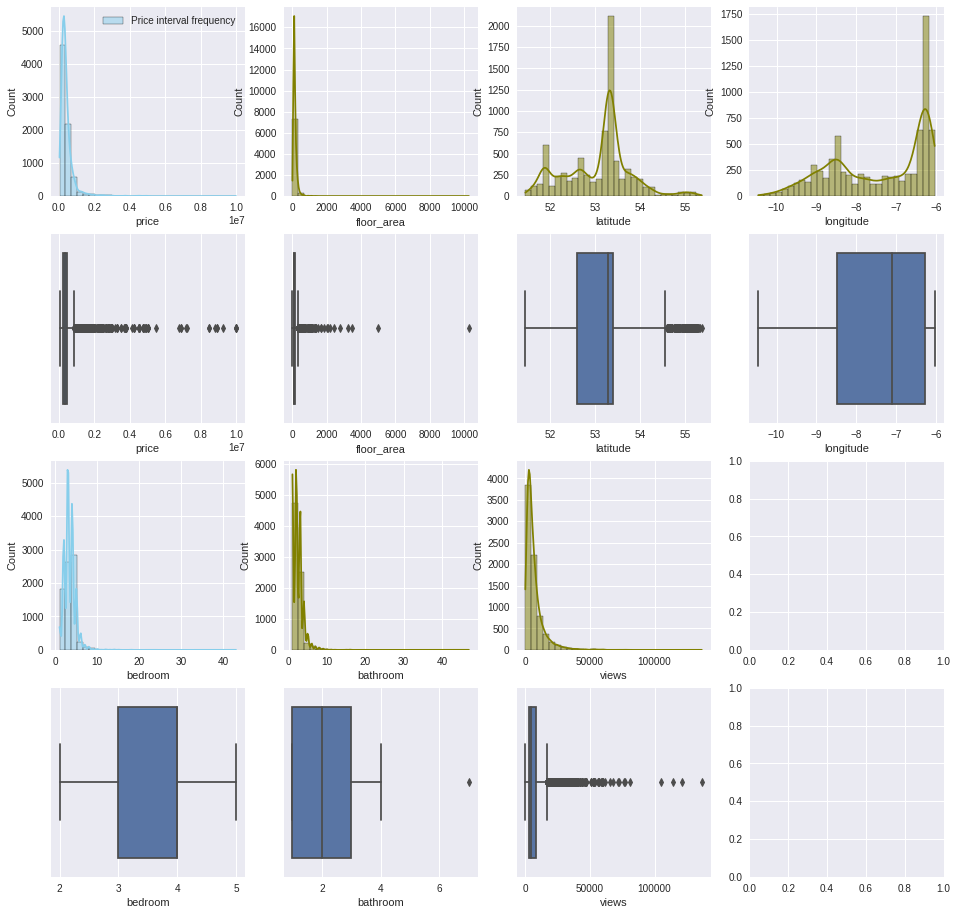

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

sns.histplot(data=sale_data.price, kde=True, bins=30, color="skyblue", ax=axs[0, 0], label='Price interval frequency')  #stat='density', label='Price interval frequency'
sns.boxplot(data=sale_data.price, x=sale_data.price, ax=axs[1, 0])
sns.histplot(data=sale_data.floor_area, kde=True, bins=30, color="olive", ax=axs[0, 1])
sns.boxplot(data=sale_data.floor_area, x=sale_data.floor_area, ax=axs[1, 1])

sns.histplot(data=sale_data.latitude, kde=True, bins=30, color="olive", ax=axs[0, 2])
sns.boxplot(data=sale_data.latitude, x=sale_data.latitude, ax=axs[1, 2])
sns.histplot(data=sale_data.longitude, kde=True, bins=30, color="olive", ax=axs[0, 3])
sns.boxplot(data=sale_data.longitude, x=sale_data.longitude, ax=axs[1, 3])

sns.histplot(data=sale_data.bedroom, kde=True, bins=30, color="skyblue", ax=axs[2, 0])  #stat='density', label='Price interval frequency'
sns.boxplot(data=sale_data.bedroom, x=sale_data.bedroom, ax=axs[3, 0])
sns.histplot(data=sale_data.bathroom, kde=True, bins=30, color="olive", ax=axs[2, 1])
sns.boxplot(data=sale_data.bathroom, x=sale_data.bathroom, ax=axs[3, 1])

sns.histplot(data=sale_data.views, kde=True, bins=30, color="olive", ax=axs[2, 2])
sns.boxplot(data=sale_data.views, x=sale_data.views, ax=axs[3, 2])

axs[0, 0].legend(); 

In [7]:
# Fisher-Pearson coefficient of skewness
ss.skew(sale_data.price) 
# => Asimetria a la derecha

8.052228514856877

In [8]:
from scipy import stats

print('Kursotis:', stats.kurtosis(sale_data.price))
print('Skewness:', stats.skew(sale_data.price))

Kursotis: 96.87977995734863
Skewness: 8.052228514856877


# Categorical Variables

In [9]:
sale_data.type_house.value_counts()

house        6479
apartment    1216
Name: type_house, dtype: int64

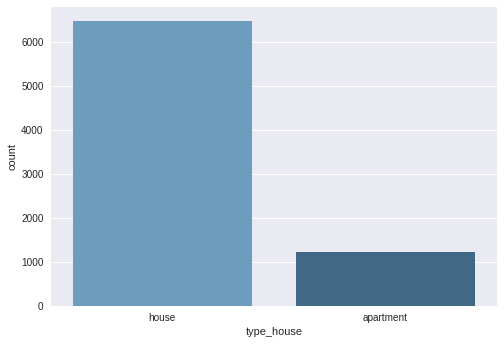

In [10]:
sns.countplot(data=sale_data, x='type_house', palette="Blues_d");

In [11]:
sale_data.drop(columns=['daft_id', 'latitude', 'longitude']).groupby(by='type_house').agg('mean')

,price,floor_area,views,bedroom,bathroom
type_house,,,,,
apartment,320578.248355,76.536184,4813.012336,2.000822,1.615954
house,463748.232598,162.828060,7189.144158,3.686063,2.488038


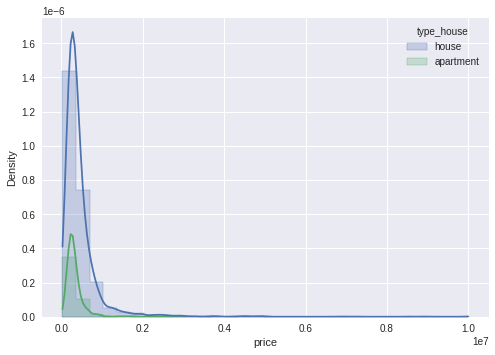

In [12]:
sns.histplot(data=sale_data, x='price', hue='type_house', legend=True, bins=30, 
             kde=True, stat='density', element="step", common_norm=True);

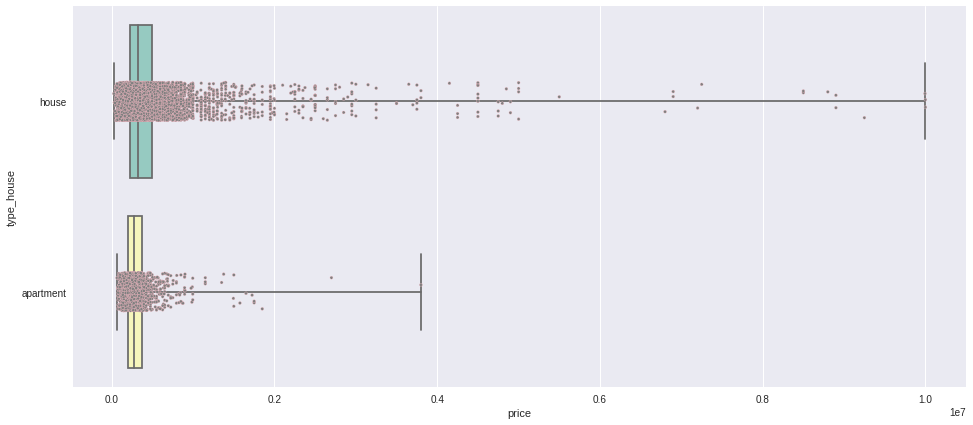

In [13]:
fig, ax = plt.subplots(figsize=(16, 7))

ax = sns.boxplot(data=sale_data, x='price', y='type_house', orient='h', 
                 order=['house', 'apartment'],
                 whis=np.inf, palette="Set3")
ax = sns.stripplot(data=sale_data, x='price', y='type_house' ,orient='h', 
                   order=['house', 'apartment'],
                   color="gray", edgecolor="pink", linewidth=.3,  size=3)

# Statistics

## Pre-Outliers Cleansing

In [14]:
sale_data.drop(columns=['daft_id']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,7695.0,441123.840026,559497.409220,25000.000000,220000.000000,315000.000000,475000.000000,1.000000e+07
floor_area,7695.0,149.191813,187.894773,1.000000,83.000000,112.000000,170.000000,1.027900e+04
views,7695.0,6813.656660,7594.513251,0.000000,2526.500000,4567.000000,8257.000000,1.364560e+05
latitude,7695.0,53.073054,0.718554,51.460139,52.607087,53.283705,53.395819,5.536339e+01
longitude,7695.0,-7.432629,1.191594,-10.459878,-8.493948,-7.109124,-6.277835,-6.027847e+00
bedroom,7695.0,3.419753,1.510908,1.000000,3.000000,3.000000,4.000000,4.300000e+01
bathroom,7695.0,2.350227,1.476052,1.000000,1.000000,2.000000,3.000000,4.700000e+01


- Measures of Position
- Measures of Dispersion
    - MD Absolutes
    - MD Relatives
    - Teorema de Tchebycheff
- Asymmetry and Kurtosis

## Post-Outliers Cleansing

### Outliers Detection

#### Percentile based method

In [15]:
def pct_method(data, level):
    # Upper and lower limits by percentiles
    upper = np.percentile(data, 100 - level)
    lower = np.percentile(data, level)
    # Returning the upper and lower limits
    return [lower, upper]

#### Interquartile range method

In [16]:
def iqr_method(data):
    # Calculating the IQR
    perc_75 = np.percentile(data, 75)
    perc_25 = np.percentile(data, 25)
    iqr_range = perc_75 - perc_25
    # Obtaining the lower and upper bound
    iqr_upper = perc_75 + 1.5 * iqr_range
    iqr_lower = perc_25 - 1.5 * iqr_range
    # Returning the upper and lower limits
    return [iqr_lower, iqr_upper]

In [17]:
# This approach only works if the data is approximately Gaussian
def std_method(data):
    # Creating three standard deviations away boundaries
    std = np.std(data)
    upper_3std = np.mean(data) + 3 * std
    lower_3std = np.mean(data) - 3 * std
    # Returning the upper and lower limits
    return [lower_3std, upper_3std]

In [28]:
def outlier_bool(df, feature, level=1, continuous=False, log=False):
    
    data = df[feature]
    
    
    
    # Taking logs is specified
    if log is True:
        data = np.log(data + 1)
    # Obtaining the ranges
    pct_range = pct_method(data, level)
    iqr_range = iqr_method(data)
    std_range = std_method(data)
    
    if continuous is False:
        # Setting the lower limit fixed for discrete variables
        low_limit = np.min(data)
        high_limit = np.max([pct_range[1],
                             iqr_range[1],
                             std_range[1]])
        
    elif continuous is True:
        if feature is 'floor_area':
            #print('si')
            low_limit = pct_range[0]
        else:
            #print('no')
            low_limit = np.min([pct_range[0],
                                iqr_range[0],
                                std_range[0]])
        high_limit = np.max([pct_range[1],
                             iqr_range[1],
                             std_range[1]])
        
    print(f'Limits: {[low_limit, high_limit]}')
# Restrict the data with the minimum and maximum
    outlier = data.between(low_limit, high_limit)
    print(f'No outliers: {outlier.sum()}')
    print(f'Outliers: {(outlier==False).sum()}\n')
    
    
# Return boolean
    return outlier

In [29]:
def drop_outliers(df, feature, level=1, continuous=False, log=False, inplace=False):
    print(f'Range before: {[df[feature].min(), df[feature].max()]}\n')
    outlier_boolean = outlier_bool(df=df, feature=feature, level=1, continuous=continuous, log=False)
    rows_before = df.shape[0]
    df = df[outlier_boolean]
    rows_after = df.shape[0]
    print(f'Range after: {[df[feature].min(), df[feature].max()]}')
    print(f'Outliers dropped: {rows_before - rows_after}')
    return df

#### Dropping `price` Outliers

In [48]:
sd_out_price = drop_outliers(sale_data, 'price', continuous=True)
sd_out_price.shape

Range before: [25000.0, 10000000.0]

Limits: [-1237259.320268431, 2650000.0]
No outliers: 7621
Outliers: 74

Range after: [25000.0, 2650000.0]
Outliers dropped: 74


(7621, 15)

In [41]:
pct_range = pct_method(sale_data.price, level=1)
iqr_range = iqr_method(sale_data.price)
std_range = std_method(sale_data.price)

print(pct_range)
print(iqr_range)
print(std_range)

[80000.0, 2650000.0]
[-162500.0, 857500.0]
[-1237259.320268431, 2119507.0003204127]


In [45]:
sale_data.price.sort_values().head() # Los quito?

1054    25000.0
7306    32000.0
6953    40000.0
7671    40000.0
7066    45000.0
Name: price, dtype: float64

#### Dropping `floor_area` Outliers

In [31]:
sale_data_out = drop_outliers(sale_data, 'floor_area', continuous=True)
sale_data_out.shape

Range before: [1, 10279]

Limits: [38.0, 712.8395035046221]
No outliers: 7575
Outliers: 120

Range after: [38, 710]
Outliers dropped: 120


(7575, 15)

Aqui no funciona muy bien porque permite valores pequegnos sin sentido para una casa. En este caso usaremos el limite inferior del percentile method, que es el mas restrictivo. 

In [40]:
pct_range = pct_method(sale_data.floor_area, level=1)
iqr_range = iqr_method(sale_data.floor_area)
std_range = std_method(sale_data.floor_area)

print(pct_range)
print(iqr_range)
print(std_range)

[38.0, 624.5399999999954]
[-47.5, 300.5]
[-414.45587777362795, 712.8395035046221]


In [46]:
sale_data.floor_area.sort_values().head()

6243    1
4072    1
7229    1
7236    1
7096    1
Name: floor_area, dtype: int64

#### Dropping `views` Outliers

In [34]:
sale_data_out = drop_outliers(sale_data, 'views', continuous=True)
sale_data_out.shape

Range before: [0.0, 136456.0]

Limits: [-15968.402634048929, 36608.39999999998]
No outliers: 7618
Outliers: 77

Range after: [0.0, 36606.0]
Outliers dropped: 77


(7618, 15)

In [39]:
pct_range = pct_method(sale_data.views, level=1)
iqr_range = iqr_method(sale_data.views)
std_range = std_method(sale_data.views)

print(pct_range)
print(iqr_range)
print(std_range)

[413.88, 36608.39999999998]
[-6069.25, 16852.75]
[-15968.402634048929, 29595.71595438681]


In [47]:
sale_data['views'].sort_values().head()

1652    0.0
5160    0.0
7048    0.0
5984    0.0
3857    0.0
Name: views, dtype: float64

#### Dropping 

In [33]:
sale_data_out.drop(columns=['daft_id']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,7575.0,429530.963564,477760.749847,25000.000000,220000.000000,315000.000000,475000.000000,8.900000e+06
floor_area,7575.0,141.077756,90.105990,38.000000,84.000000,112.000000,168.000000,7.100000e+02
views,7575.0,6671.947723,6972.090094,0.000000,2506.500000,4533.000000,8204.000000,8.118800e+04
latitude,7575.0,53.077770,0.717805,51.460139,52.625920,53.284525,53.397481,5.536339e+01
longitude,7575.0,-7.426586,1.187277,-10.459878,-8.491297,-7.107007,-6.277164,-6.027847e+00
bedroom,7575.0,3.404356,1.356772,1.000000,3.000000,3.000000,4.000000,1.800000e+01
bathroom,7575.0,2.331881,1.331687,1.000000,1.000000,2.000000,3.000000,1.600000e+01


# Relationships

In [ ]:
sns.pairplot(sale_data.drop(columns=['daft_id']), hue='type_house');

In [ ]:
sns.heatmap(sale_data.corr(), annot=True, cmap='mako');  

https://medium.com/towards-data-science/rip-correlation-introducing-the-predictive-power-score-3d90808b9598